# Building a concept map
### Generating a graph of linked concepts
### Recommending learning paths based on student background

First we load extracted concepts from file. 

In [93]:
filename = 'starwiki'

concepts = {}
import pickle
# Loading extracted concepts from file (see concept_extraction.ipynb)
#concepts = {'sents':sents,'rawtxt':rawtxt,'sent_to_npflat':sent_to_npflat,'sent_to_tags':sent_to_tags,'sent_to_ltags':sent_to_ltags,'np_to_sent':np_to_sent,'Conceptdata':Conceptdata}
with open(filename +'concepts.pickle', 'rb') as f:
    concepts = pickle.load(f)
f.close()

# Loading idf dictionary (see Build_IDF_dictionary.ipynb)
with open('idf_dict.pickle','rb') as f1:
    idf_dict =pickle.load(f1)
f1.close()

sents = concepts['sents']
rawtxt = concepts['rawtxt']
sent_to_npflat = concepts['sent_to_npflat']
sent_to_tags= concepts['sent_to_tags']
sent_to_ltags = concepts['sent_to_ltags']
np_to_sent = concepts['np_to_sent']
Conceptdata = concepts['Conceptdata']

Function to get undirected graph between two concepts, weight value is inversely proportional to number of sentences between the two concepts. 

Bond strength = summation of 1/(1+sentence distance) for every time they occur within (max - min) sentence distance

1. max_sent_dist : the maximum sentence between first concept and second concept to consider as linked
2. min_sent_dist : (typically zero) minimum sentence distance between first and second concept to consider as linked
3. sent_to_npflat: dictionary : key: (sentence number in text), value: (list of concepts in the sentence) 


In [94]:
def build_graph(sent_to_npflat,max_sent_dist, min_sent_dist):
    npnp_bondstrengthdir = {}
    for i in range(len(sent_to_npflat)-max_sent_dist):
        for np1 in sent_to_npflat[i]:
            npnp_bondstrengthdir[np1] = {}
            for j in range(min_sent_dist, max_sent_dist):
                np2list = [np2 for np2 in sent_to_npflat[i+j] if np2!=np1]
                for np2 in np2list:
                    npnp_bondstrengthdir[np1][np2] =npnp_bondstrengthdir[np1].get(np2,0) + 1/(j+1)
    return npnp_bondstrengthdir

In [95]:
# Function for term frequency
def tf(np,rawtxt):
   p = re.compile(np)
   return len(p.findall(rawtxt.lower()))        

# Function for IDF
import math
totaldocs = 10788
def get_idf(wrd,totaldocs):
    wrd = wrd.lower()
    return idf_dict.get(wrd,math.log(totaldocs))


In [96]:
# function to find shortest distance (used for graph relationship weight calculations)
import bisect as bs

def find_shortest_distance(search_list, value):
    ins_point = bs.bisect_right(search_list,value)
    if ins_point < len(search_list):
        return min(abs(search_list[ins_point] - value), abs(search_list[ins_point - 1] - value))
    return abs(search_list[ins_point - 1] - value)


In [97]:
npnp_bondstrengthdir = build_graph(sent_to_npflat,3,0)

### Building a data frame with every relationship and metrics about individual concepts and their relationship

Metrics to calculate the importance of the individual concepts, importance of the relationship between them, and directionality.

Directionality: Does knowing ConceptA aid in understanding ConceptB? 

In [106]:
import itertools
from itertools import chain
import numpy as num

lensents = len(sents)
lennp = len(np_to_sent)
Concept1 = [[np1]*len(npnp_bondstrengthdir[np1]) for np1 in npnp_bondstrengthdir.keys()]
Concept1 = list(chain.from_iterable(Concept1))
Concept2 = [np2 for np1 in npnp_bondstrengthdir.keys() for np2 in npnp_bondstrengthdir[np1].keys()]

Bondstrength = [npnp_bondstrengthdir[Concept1[i]][Concept2[i]] for i in range(len(Concept1))]

# Number of sentences in which concept occurs
FA = [len(np_to_sent[np1]) for np1 in Concept1]
FB = [len(np_to_sent[np2]) for np2 in Concept2]

# std deviation of occurence of concept: the spread - does it occur all over the document or just in one section. 
SdevA = [num.std(np_to_sent[np1]) for np1 in Concept1]
SdevB = [num.std(np_to_sent[np2]) for np2 in Concept2]

## Computing the mean bond strength of concept X to other concepts (compared with Bondstrength, gives an idea of how 
## strongly X is related to Y in comparison with other concepts)
meanBSA = [num.mean(list(npnp_bondstrengthdir[np1].values())) for np1 in Concept1]
meanBSB = [num.mean(list(npnp_bondstrengthdir.get(np2,{}).values())) for np2 in Concept2]


## Computing average shortest distance of each A to a B and vice versa. A metric for co-occurence of the two concepts
OcA = [np_to_sent[np1] for np1 in Concept1]
OcB = [np_to_sent[np2] for np2 in Concept2]

dAB=[]
dBA=[]

for i in range(len(Concept1)):
    dAB.append(num.mean([abs(find_shortest_distance(OcB[i],o)) for o in OcA[i]]))
    dBA.append(num.mean([abs(find_shortest_distance(OcA[i],o)) for o in OcB[i]]))
    

## Computing number of mappings for Concept1, Concept2 respectively and how many of those concepts intersect
Amap = [len(npnp_bondstrengthdir[np1]) for np1 in Concept1]
Bmap = [len(npnp_bondstrengthdir.get(np2,{})) for np2 in Concept2]
AmapintersectBmap = [len(set(npnp_bondstrengthdir[Concept1[i]].keys()) & set(npnp_bondstrengthdir.get(Concept2[i],{}).keys())) for i in range(len(Concept1))]

## How many concepts is A linked to that B is NOT linked to, and vice versa
AminusB = [Amap[i]-AmapintersectBmap[i] for i in range(len(Concept1))]
BminusA = [Bmap[i]-AmapintersectBmap[i] for i in range(len(Concept1))]




## First occurence of A and B wrt length of text
AfirstOc = [np_to_sent[np1][0]/lensents for np1 in Concept1]
BfirstOc = [np_to_sent[np2][0]/lensents for np2 in Concept2]


## IDF value for each concept (1-gram IDF dictionary. using average for multi word concept phrases)
nptoWtkeys = list(np_to_sent.keys())
nptoWtvals = [np.split() for np in nptoWtkeys]
nptoWt = dict(zip(nptoWtkeys,nptoWtvals))
nptoIDFvals = [num.mean([get_idf(t,totaldocs) for t in nptoWt[np1]]) for np1 in nptoWt.keys()]
nptoIDF = dict(zip(nptoWtkeys,nptoIDFvals))
IDFA = [nptoIDF[np1] for np1 in Concept1]
IDFB = [nptoIDF[np2] for np2 in Concept2]

## Seeing if one concept phrase is present in the other: example: long-term memory, memory. 
AinB = [1 if (len(Concept1[i])>0)and(Concept1[i] in Concept2[i]) else 0 for i in range(len(Concept1))]
BinA = [1 if (len(Concept2[i])>0)and(Concept2[i] in Concept1[i]) else 0 for i in range(len(Concept1))]

In [107]:
import pandas as pd
print('making into dataframe')

df = pd.DataFrame({'Concept1':Concept1,'Concept2': Concept2,'FA':FA,'FB':FB,'SdevA':SdevA,'SdevB':SdevB,'Bondstrength':Bondstrength, 'meanBSA':meanBSA, 'meanBSB':meanBSB,'dAB':dAB,'dBA':dBA,'Amap':Amap,'Bmap':Bmap,'AmapintersectBmap':AmapintersectBmap, 'AminusB':AminusB, 'BminusA':BminusA,'AfirstOc':AfirstOc,'BfirstOc':BfirstOc,'IDFA':IDFA,'IDFB':IDFB, 'AinB':AinB, 'BinA':BinA })

making into dataframe


In [108]:
# Looking at some of the concept1-concept2 links. 

print('Total number of relationships in graph', len(df))
df.sort_values(by=['FA','FB','SdevA','SdevB','Amap','Bmap'],ascending=[False]*6).head(20)

Total number of relationships in graph 19011


,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,Bmap,AmapintersectBmap,AminusB,BminusA,AfirstOc,BfirstOc,IDFA,IDFB,AinB,BinA
28,star,energy,177,16,137.913263,169.322628,1.000000,0.703704,0.710526,31.209040,...,19,0,9,19,0.000000,0.012270,6.108136,3.527288,0,0
27,star,reaction,177,4,137.913263,1.870829,1.000000,0.703704,0.607843,251.847458,...,17,0,9,17,0.000000,0.975460,6.108136,5.081497,0,0
30,star,hydrogen gas molecule,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,10,5,4,5,0.000000,0.981595,6.108136,7.088508,0,0
31,star,combustion,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,10,5,4,5,0.000000,0.981595,6.108136,7.088965,0,0
32,star,comparison,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,10,5,4,5,0.000000,0.981595,6.108136,5.414989,0,0
33,star,oxygen gas molecule,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,10,5,4,5,0.000000,0.981595,6.108136,7.088508,0,0
34,star,ev,177,1,137.913263,0.000000,0.333333,0.703704,0.433333,255.819209,...,10,1,8,9,0.000000,0.983640,6.108136,9.286190,0,0
26,star,radiation output,177,1,137.913263,0.000000,1.000000,0.703704,0.703704,253.841808,...,9,8,1,1,0.000000,0.979550,6.108136,5.489251,0,0
29,star,however enormous number,177,1,137.913263,0.000000,1.000000,0.703704,0.703704,253.841808,...,9,8,1,1,0.000000,0.979550,6.108136,4.392850,0,0
74,sun,star,46,177,142.339493,137.913263,0.333333,0.850877,0.703704,1.239130,...,9,4,15,5,0.002045,0.000000,5.436042,6.108136,0,0


## Concept importance, Relationship importance and Directionality hypotheses

Before we make the concept graph, we need to ensure the graph is directed and acyclic so it is clear which concept should be learned first, and which topic is more advanced. 

In the absence of annotated concept direction data, (plan to get 'prerequisite' and 'aiding word' information from wikipedia articles), for now, we can look at some hypotheses on directionality, and concept and relationship importance. 

### Concept importance: Is this an important concept in this text?
#### Hypotheses:
1. Higher TF value makes concept more important
2. Higher SdevA,SdevB : concepts are spread out throughout the text
3. Amap: how many concepts ConceptA maps to, the higher the more important the concept.  
4. AfirstOc: how early in the text does A appear
5. Higher Inverse Docuemnt Frequency value makes concept more important

Are all of the above correlated with each other? As in, are we including too many terms? 

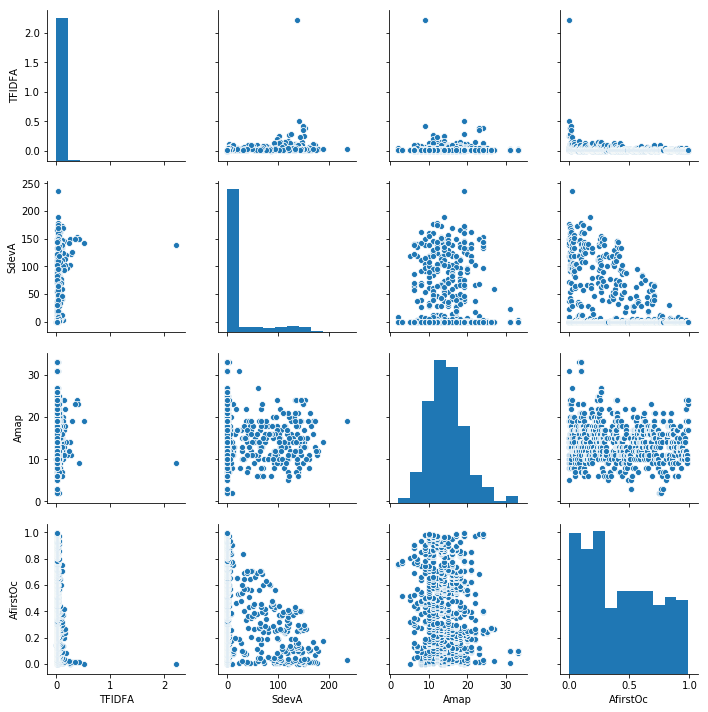

In [109]:
# subsetting concept1's metrics and dropping duplicates to avoid recounting
df['TFA'] = df['FA']/lensents
df['TFB'] = df['FB']/lensents
df['TFIDFA'] = df['TFA']*df['IDFA']
df['TFIDFB'] = df['TFB']*df['IDFB']
dfConceptimp = df.copy().loc[:,['Concept1','TFIDFA','SdevA','Amap','AfirstOc']].drop_duplicates()

import seaborn as sns
sns.pairplot(dfConceptimp)

In [110]:
dfConceptimp.sort_values(by=['TFIDFA','Amap','SdevA','AfirstOc'],ascending=[False,False,False,True]).head(25)

,Concept1,TFIDFA,SdevA,Amap,AfirstOc
26,star,2.210920,137.913263,9,0.000000
57,sun,0.511366,142.339493,19,0.002045
636,luminosity,0.417784,149.816975,9,0.018405
464,core,0.395449,149.381637,23,0.012270
440,helium,0.379803,153.070049,24,0.012270
661,mass,0.346326,149.109903,23,0.018405
522,hydrogen,0.281163,125.662106,19,0.012270
297,astronomer,0.265862,121.987370,11,0.008180
321,galaxy,0.251153,101.982656,14,0.010225
43,earth,0.250541,150.289225,14,0.002045


This seems to be a reasonable way to order concepts for their importance.

### Relationship importance: 
#### Hypotheses: 

1. The higher the bondstrength, the more important the relationship
2. Bondstrength - mean(meanBSA,meanBSB). If bondstrength between A-B is higher than the bondstrength of A with other concepts, and B with other concepts, then the relationship is important. 
3. Low values of min(dAB,dBA) (high co-occurence of A wrt B or B wrt A)
4. High value of AmapintersectBmap (A and B link to a lot of the same concepts)

In [120]:
df['Bondstrengthdiff'] = df['Bondstrength']-(df['meanBSA']+df['meanBSB'])/2
df['mean_dAB'] = (df['dAB']+df['dBA'])/2
dfRelImp = df.copy().loc[:,['Concept1','Concept2','mean_dAB','Bondstrengthdiff','AmapintersectBmap']]
dfRelImp.sort_values(by=['AmapintersectBmap','mean_dAB','Bondstrengthdiff'],ascending = [False,True,False]).head(15)

,Concept1,Concept2,mean_dAB,Bondstrengthdiff,AmapintersectBmap
2800,josep puig,continuous image,0.0,0.353535,32
2801,josep puig,refraction,0.0,0.353535,32
2804,josep puig,ah,0.0,0.353535,32
2805,josep puig,sublunary material,0.0,0.353535,32
2806,josep puig,andalusian astronomer ibn bajjah,0.0,0.353535,32
2807,josep puig,conjunction,0.0,0.353535,32
2844,continuous image,josep puig,0.0,0.353535,32
2848,continuous image,refraction,0.0,0.353535,32
2851,continuous image,ah,0.0,0.353535,32
2852,continuous image,sublunary material,0.0,0.353535,32


### Directionality: 
Would knowing Concept A aid in understanding Concept B? 
It is difficult to define this - it could mean that Concept A is a pre-requisite for defining Concept B (temperature -> thermometer), or not, but still play an important role in the explanation. (winter -> thermometer)

After a point, it also depends on the student's background, and feedback would be required. 
Nevertheless, nothing is stopping us from making some rule-based decisions yet. 

#### Hypotheses:
1. Higher AminusB than BminusA, the more concepts A is linked to that B is not linked to, the more likely that A directs to B than vice versa 
2. Difference between dAB and dBA (if B co-occurs with A very often, but A does not, then A more likely directs to B, than vice versa
3. If the IDF value of A is lower than B, then A more likely directs to B, than vice versa
4. If AinB is 1, then A more likely directs to B than vice versa (Example: ConceptA:'memory', ConceptB 'traumatic memory')

In [113]:
df['AminusB_BminusA_diff'] = df['AminusB'] - df['BminusA']
df['dAB_dBA_diff'] = df['dAB']-df['dBA']
df['IDFA_IDFB_diff'] = df['IDFA']-df['IDFB']
dfDirectional = df.copy().loc[:,['Concept1','Concept2','AminusB_BminusA_diff','dAB_dBA_diff','IDFA_IDFB_diff','AinB']]
dfDirectional.sort_values(by = ['AinB'],ascending=[False]*4).head(5)

,Concept1,Concept2,AminusB_BminusA_diff,dAB_dBA_diff,IDFA_IDFB_diff,AinB
529,hydrogen,hydrogen fuse,0,282.687500,0.000000,1
470,core,contracting core,-1,219.428571,-0.681652,1
505,energy,so further energy,0,170.187500,0.379446,1
3990,strength,hydrogen line strength,5,167.000000,-0.756989,1
7513,region,chromosphere region,-4,161.600000,-2.326980,1


In [115]:
dfDirectional.sort_values(by='AminusB_BminusA_diff',ascending=False).head(5)

,Concept1,Concept2,AminusB_BminusA_diff,dAB_dBA_diff,IDFA_IDFB_diff,AinB
2982,sublunary material,night sky,26,-186.0,0.651787,0
3048,conjunction,night sky,26,-186.0,0.377804,0
2100,ad,night sky,26,-182.0,0.442343,0
2809,josep puig,night sky,26,-186.0,3.150393,0
2856,continuous image,night sky,26,-186.0,0.285343,0


In [116]:
dfDirectional.sort_values(by='dAB_dBA_diff',ascending=False).head(5)

,Concept1,Concept2,AminusB_BminusA_diff,dAB_dBA_diff,IDFA_IDFB_diff,AinB
1057,heavy element,stellar nucleosynthesis process,5,296.090909,-2.748917,0
1059,heavy element,so further energy,5,296.090909,1.799202,0
1050,heavy element,triple-alpha process,0,296.090909,-1.953803,0
1055,heavy element,intermediate element beryllium,0,296.090909,-1.777091,0
1070,heavy element,nuclear fuel,24,296.090909,-0.274558,0


In [119]:
dfDirectional.sort_values(by='IDFA_IDFB_diff',ascending=True).head(10)

,Concept1,Concept2,AminusB_BminusA_diff,dAB_dBA_diff,IDFA_IDFB_diff,AinB
10879,a,algol,0,69.000000,-8.774468,1
10876,a,binary,0,-9.900000,-8.774468,1
4392,s,computation,-3,0.000000,-8.509161,0
4390,s,astronomer,-1,-103.000000,-8.509161,1
5335,year,luminosity,9,-18.004545,-8.253488,0
5345,year,mira,1,220.250000,-8.253488,0
5344,year,cepheid,1,220.250000,-8.253488,0
16569,v,vii,0,0.000000,-8.014005,1
16566,v,hypergiants,0,0.000000,-8.014005,0
11243,billion,stellar,8,17.000000,-7.437795,0


### Conclusions and next steps:
Overall, it looks like, in descending order AinB is a strong indicator of direction, as is dAB_dBA_diff. To a lesser extent AminusB_BminusA, and IDFA_IDFB. 

This should also factor into the weights. 
It would be a good idea to maybe annotate directions manually, (or from wikipedia articles), and do a regression to get direction. 

For now, I am using conditionals, and only a binary value for direction:
    if AinB==1: then direction is 1
    else if AinB==0, then if dAB_dBA_diff > 0, then direction is 1
    else if dAB_dBA_diff==0, then if IDFA_IDFB_diff>0, then direction is 1

#### Assigning directions:

In [126]:
# Assigning directions
df['Direction'] = (df['AinB']==1) | ((df['AinB']==0) & (df['dAB_dBA_diff']>0)) | ((df['AinB']==0) & (df['dAB_dBA_diff']==0) & (df['IDFA_IDFB_diff']>0))
df[df['Direction']==1].sort_values(by='FA',ascending=False).head(15)

,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,TFA,TFB,TFIDFA,TFIDFB,Bondstrengthdiff,mean_dAB,AminusB_BminusA_diff,dAB_dBA_diff,IDFA_IDFB_diff,Direction
30,star,hydrogen gas molecule,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,0.361963,0.002045,2.210920,0.014496,-0.126852,127.915254,-1,253.830508,-0.980372,True
33,star,oxygen gas molecule,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,0.361963,0.002045,2.210920,0.014496,-0.126852,127.915254,-1,253.830508,-0.980372,True
26,star,radiation output,177,1,137.913263,0.000000,1.000000,0.703704,0.703704,253.841808,...,0.361963,0.002045,2.210920,0.011225,0.296296,126.920904,0,253.841808,0.618885,True
27,star,reaction,177,4,137.913263,1.870829,1.000000,0.703704,0.607843,251.847458,...,0.361963,0.008180,2.210920,0.041566,0.344227,126.673729,-8,250.347458,1.026639,True
28,star,energy,177,16,137.913263,169.322628,1.000000,0.703704,0.710526,31.209040,...,0.361963,0.032720,2.210920,0.115412,0.292885,15.979520,-10,30.459040,2.580848,True
29,star,however enormous number,177,1,137.913263,0.000000,1.000000,0.703704,0.703704,253.841808,...,0.361963,0.002045,2.210920,0.008983,0.296296,126.920904,0,253.841808,1.715286,True
34,star,ev,177,1,137.913263,0.000000,0.333333,0.703704,0.433333,255.819209,...,0.361963,0.002045,2.210920,0.018990,-0.235185,128.909605,-1,253.819209,-3.178054,True
31,star,combustion,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,0.361963,0.002045,2.210920,0.014497,-0.126852,127.915254,-1,253.830508,-0.980829,True
32,star,comparison,177,1,137.913263,0.000000,0.500000,0.703704,0.550000,254.830508,...,0.361963,0.002045,2.210920,0.011074,-0.126852,127.915254,-1,253.830508,0.693147,True
69,sun,tiny amount,46,1,142.339493,0.000000,0.500000,0.850877,0.712121,215.739130,...,0.094070,0.002045,0.511366,0.011669,-0.281499,108.369565,8,214.739130,-0.270113,True


### Graph drawing and learning paths:

6086
Including the following concepts : ['star', 'sun', 'luminosity', 'core', 'helium']
The nodes that connect these concepts:  ['core', 'h', 'helium', 'sun', 'energy', 'main sequence star', 'luminosity', 'star']
{'core', 'h', 'sun', 'energy', 'main sequence star', 'star'}
{'main sequence star', 'energy', 'h', 'helium'}


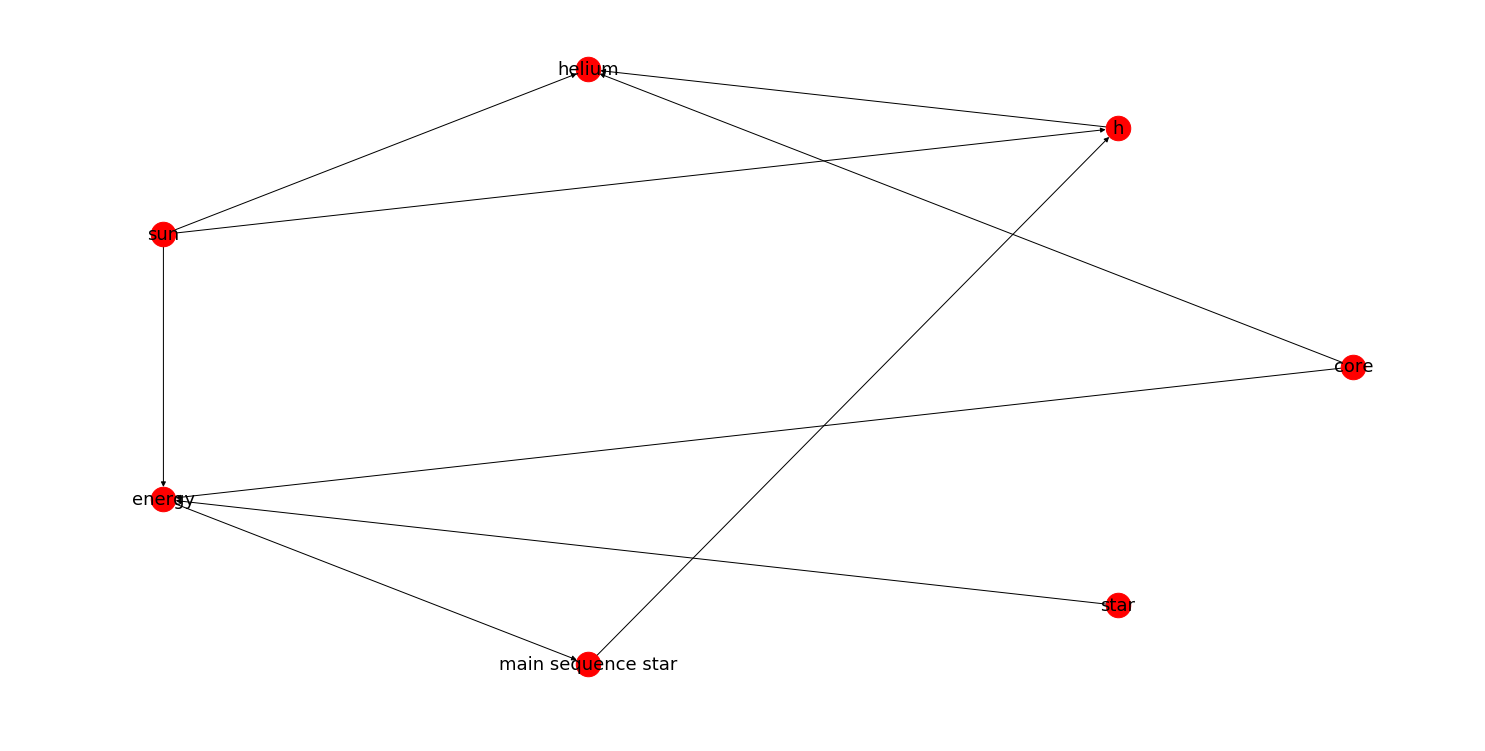

In [132]:
dfdir = df[df['Direction']>=1]
print(len(dfdir))

include_concepts_number = 5 # Start drawing graph with top 20 concepts

import networkx as nx
G = nx.from_pandas_edgelist(dfdir,'Concept1','Concept2', create_using=nx.DiGraph())
dfConceptimp.sort_values(by=['TFIDFA'],ascending = [0]).head(include_concepts_number)
paths=dict(nx.all_pairs_shortest_path(G,cutoff=None))


def get_nodes_allpairs(concept_list):
    nodelist = [paths.get(cl1, {}).get(cl2,None) for cl1 in concept_list for cl2 in concept_list if paths.get(cl1, {}).get(cl2,None) is not None]
    nodelist = list(chain.from_iterable(nodelist))
    return list(set(nodelist))


start_concept_list = list(dfConceptimp.sort_values(by=['TFIDFA'],ascending = [0]).head(include_concepts_number)['Concept1'])

print('Including the following concepts :',start_concept_list)

# now get the paths from all pairs in the concept list and the corresponding nodes 
nodelist = get_nodes_allpairs(start_concept_list)
print('The nodes that connect these concepts: ', nodelist)
start_concept_edges = dfdir[dfdir['Concept1'].isin(nodelist) & dfdir['Concept2'].isin(nodelist)]
start_concept_from = set(start_concept_edges['Concept1'])
#print(start_concept_edges)
print(start_concept_from)
start_concept_to = set(start_concept_edges['Concept2'])
print(start_concept_to)
len(start_concept_edges)
plt.figure(figsize=(20,10))
nx.draw_circular(G.subgraph(list(start_concept_from|start_concept_to)),with_labels=True, font_size=18,node_size=600)
